# Credit Card Fraud Detection – Model Tuning and API Deployment
---
This notebook implements the complete workflow described in the formal project specification. It includes data loading, exploratory data analysis, model training, tuning, evaluation, and model serialization.

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import pickle


## 1. Data Loading and Preparation

In [ ]:

# Load dataset
url = 'https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv'
df = pd.read_csv(url)

# Rename columns for interpretability
rename_map = {
    'Time': 'transaction_time',
    'Amount': 'transaction_amount',
    'Class': 'is_fraud'
}
for i in range(1, 29):
    rename_map[f'V{i}'] = f'V{i}_feature'
df.rename(columns=rename_map, inplace=True)

df.head()


KeyboardInterrupt: 

## 2. Exploratory Data Analysis

,transaction_time,V1_feature,V2_feature,V3_feature,V4_feature,V5_feature,V6_feature,V7_feature,V8_feature,V9_feature,...,V21_feature,V22_feature,V23_feature,V24_feature,V25_feature,V26_feature,V27_feature,V28_feature,transaction_amount,is_fraud
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


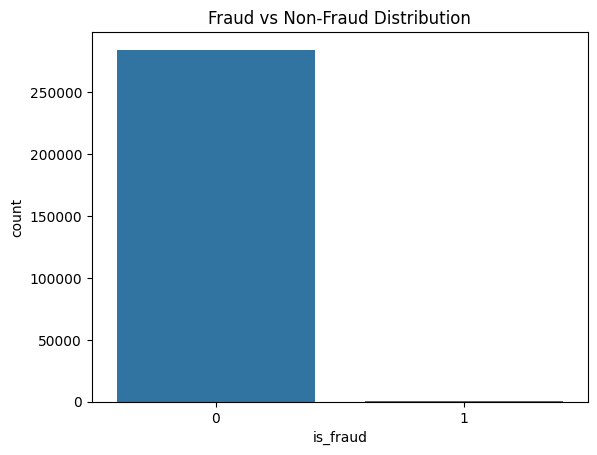

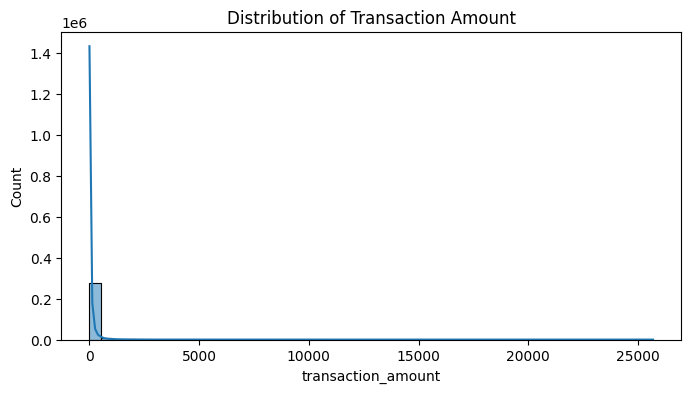

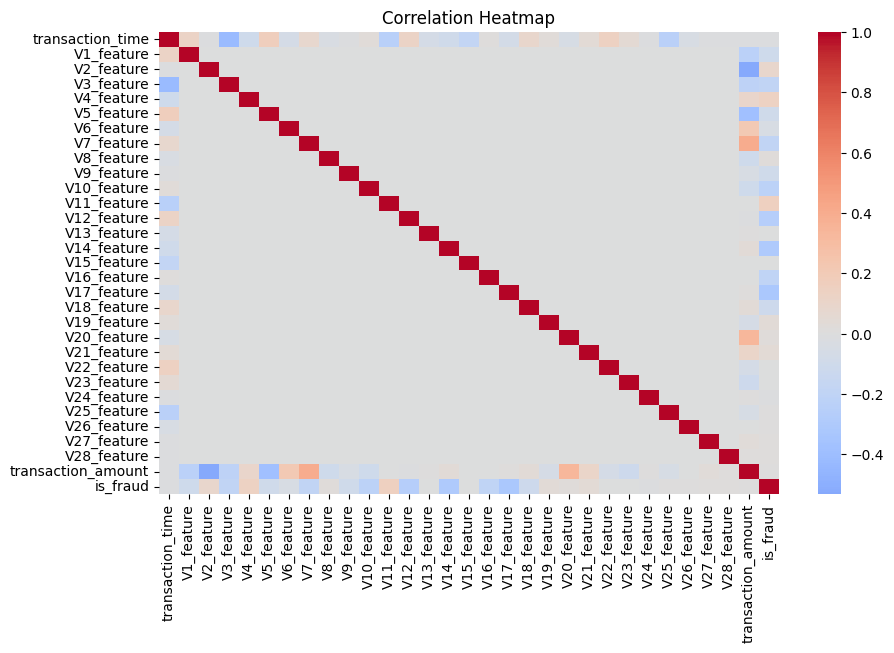

In [ ]:

# Summary statistics
display(df.describe())

# Fraud vs non-fraud distribution
sns.countplot(data=df, x='is_fraud')
plt.title('Fraud vs Non-Fraud Distribution')
plt.show()

# Distribution of transaction amount
plt.figure(figsize=(8,4))
sns.histplot(df['transaction_amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amount')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,6))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()


## 3. Data Splitting and Scaling

In [ ]:

X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## 4. Model Training and Hyperparameter Tuning

In [ ]:

# Grid Search for RandomForestClassifier
params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=params,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train_scaled, y_train)
print("Best parameters:", grid.best_params_)
best_model = grid.best_estimator_


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time= 1.1min
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time= 1.1min
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time= 1.1min
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time= 1.1min
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time= 1.1min
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time= 1.1min
[CV] END max_depth=10, min_samples_split=5, n_estimators=200; total time= 2.2min
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time= 2.2min
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time= 2.2min
[CV] END max_depth=10, min_samples_split=5, n_estimators=200; total time= 2.2min
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time= 2.2min
[CV] END max_depth=10, min_samples_split=5, n_es

## 5. Model Evaluation

In [ ]:

y_pred = best_model.predict(X_test_scaled)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[56862     2]
 [   23    75]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.77      0.86        98

    accuracy                           1.00     56962
   macro avg       0.99      0.88      0.93     56962
weighted avg       1.00      1.00      1.00     56962



## 6. Save Model for Deployment

In [ ]:

with open('model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("Model saved as model.pkl")


Model saved as model.pkl
